00:00 - Режим переключен на ночной (мигающий желтый)
00:01 - Прибыл легковой с запад
00:03 - Прибыл легковой с север
00:04 - Прибыл легковой с север
00:06 - Прибыл легковой с север
00:08 - Прибыл легковой с юг
00:11 - Прибыл легковой с запад
00:12 - Прибыл легковой с запад
00:15 - Прибыл легковой с север
00:22 - Прибыл фура с запад
00:25 - Прибыл легковой с север
00:27 - Прибыл легковой с юг
00:29 - Прибыл легковой с север
00:30 - Прибыл легковой с север
00:32 - Прибыл легковой с юг
00:34 - Прибыл легковой с юг
00:35 - Прибыл легковой с север
00:40 - Прибыл грузовой с запад
00:42 - Прибыл легковой с восток
00:45 - Прибыл легковой с запад
00:47 - Прибыл легковой с юг
00:50 - Прибыл легковой с юг
00:52 - Прибыл легковой с восток
00:54 - Прибыл легковой с восток
00:57 - Прибыл легковой с север
00:60 - Прибыл легковой с восток
01:07 - Прибыл фура с запад
01:13 - Прибыл фура с север
01:15 - Прибыл легковой с восток
01:17 - Прибыл легковой с восток
01:24 - Прибыл грузовой с юг
01:26 - Прибыл

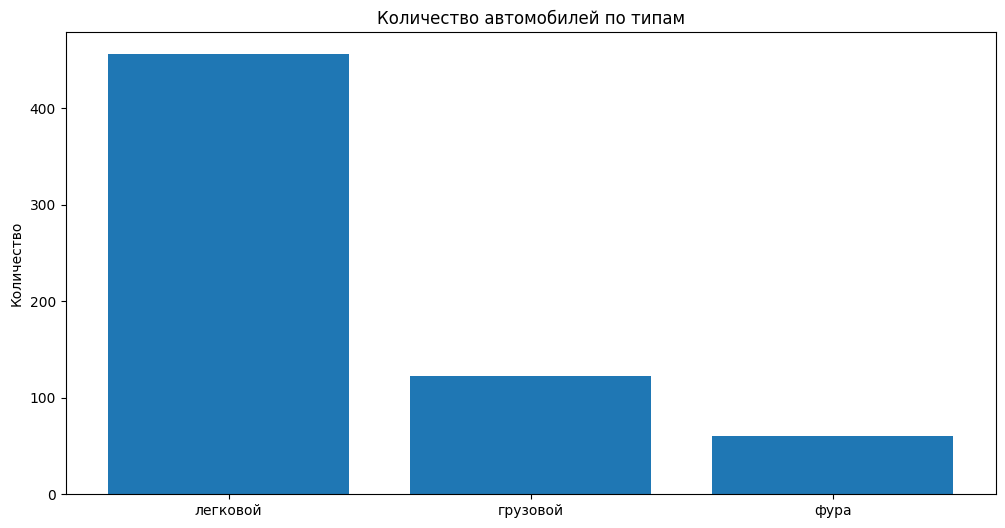

In [ ]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

SIMULATION_TIME = 24 * 60 
TRAFFIC_LIGHT_CYCLE = 2  
DAY_START, DAY_END = 6 * 60, 24 * 60  

CAR_TYPES = ['легковой', 'грузовой', 'фура']
CROSSING_TIMES = {'легковой': 0.5, 'грузовой': 0.7, 'фура': 1.0}  

DAY_ARRIVAL_RATES = {
    'легковой': (0.5, 2.0),
    'грузовой': (2.0, 5.0),
    'фура': (3.0, 8.0)
}

NIGHT_ARRIVAL_RATES = {
    'легковой': (1.0, 3.0),
    'грузовой': (3.0, 7.0),
    'фура': (5.0, 10.0)
}

DIRECTIONS = ['север', 'восток', 'юг', 'запад']
DIRECTION_ORDER = ['север', 'восток', 'юг', 'запад'] 

class TrafficLight:
    def __init__(self, env):
        self.env = env
        self.current_green = None
        self.is_night = False
        self.change_light = env.event()
        self.process = env.process(self.run())
        
    def run(self):
        while True:
            current_time = self.env.now % (24 * 60)
            
            if DAY_START <= current_time < DAY_END:
                # Дневной режим - работающий светофор
                if self.is_night:
                    self.is_night = False
                    print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - Режим переключен на дневной")
                    self.change_light.succeed()
                    self.change_light = self.env.event()
                
                # Циклическое переключение светофора
                for direction in DIRECTION_ORDER:
                    self.current_green = direction
                    self.change_light.succeed()
                    self.change_light = self.env.event()
                    print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - Зеленый для {direction}")
                    yield self.env.timeout(TRAFFIC_LIGHT_CYCLE)
            else:
                # Ночной режим - мигающий желтый
                if not self.is_night:
                    self.is_night = True
                    self.current_green = None
                    self.change_light.succeed()
                    self.change_light = self.env.event()
                    print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - Режим переключен на ночной (мигающий желтый)")
                yield self.env.timeout(1) 

class Intersection:
    def __init__(self, env):
        self.env = env
        self.traffic_light = TrafficLight(env)
        self.stats = {
            'cars_passed': defaultdict(int),
            'cars_waiting_time': defaultdict(list),
            'queue_lengths': defaultdict(list)
        }
        
    def car_arrival(self, car_type, direction):
        arrival_time = self.env.now
        print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - Прибыл {car_type} с {direction}")
        
        # Ждем зеленый свет или ночной режим
        yield self.traffic_light.change_light  
            
        if not self.traffic_light.is_night and self.traffic_light.current_green != direction:
            print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - {car_type} с {direction} ждет зеленого света")
            wait_start = self.env.now
            while self.traffic_light.current_green != direction:
                yield self.traffic_light.change_light
            waiting_time = self.env.now - wait_start
            self.stats['cars_waiting_time'][car_type].append(waiting_time)
            print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - {car_type} с {direction} дождался зеленого, ждал {waiting_time:.1f} мин")
        
        yield self.env.timeout(CROSSING_TIMES[car_type])
        self.stats['cars_passed'][car_type] += 1
        print(f"{self.env.now//60:02.0f}:{self.env.now%60:02.0f} - {car_type} с {direction} проехал перекресток")

def car_generator(env, intersection):
    while True:
        current_time = env.now % (24 * 60)
        is_day = DAY_START <= current_time < DAY_END
        
        car_type = random.choices(CAR_TYPES, weights=[0.7, 0.2, 0.1])[0]

        direction = random.choice(DIRECTIONS)
        
        # Определяем интервал прибытия в зависимости от времени суток
        if is_day:
            min_interval, max_interval = DAY_ARRIVAL_RATES[car_type]
        else:
            min_interval, max_interval = NIGHT_ARRIVAL_RATES[car_type]
            
        interval = random.uniform(min_interval, max_interval)
        yield env.timeout(interval)
        
        env.process(intersection.car_arrival(car_type, direction))

def run_simulation():
    env = simpy.Environment()
    intersection = Intersection(env)
    env.process(car_generator(env, intersection))
    env.run(until=SIMULATION_TIME)
    
    print("\n=== Результаты моделирования ===")
    total_cars = sum(intersection.stats['cars_passed'].values())
    print(f"Всего автомобилей проехало: {total_cars}")
    
    for car_type in CAR_TYPES:
        count = intersection.stats['cars_passed'][car_type]
        avg_wait = np.mean(intersection.stats['cars_waiting_time'][car_type]) if intersection.stats['cars_waiting_time'][car_type] else 0
        print(f"{car_type.capitalize()}: {count} авто, среднее время ожидания {avg_wait:.2f} мин")
    
    plt.figure(figsize=(12, 6))
    plt.bar(intersection.stats['cars_passed'].keys(), intersection.stats['cars_passed'].values())
    plt.title("Количество автомобилей по типам")
    plt.ylabel("Количество")
    plt.show()

if __name__ == "__main__":
    run_simulation()